In [1]:
#!pip install pycaret[full]
#!pip install explainerdashboard
#!pip install --upgrade fairlearn==0.7.0 raiwidgets
#!pip install scikit-learn==0.23.2

# Data Import

## Import Modules

In [59]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import setup, compare_models, tune_model, evaluate_model, plot_model, finalize_model, save_model, add_metric, get_config, set_config, get_logs
from utils import  adapt_datatype, add_datetime_to_filename

ImportError: cannot import name 'add_datetime_to_filename' from 'utils' (e:\GoogleDrive\Beruf\Freelancing\Code_Repo\Customer_Analytics\Churn_Prediction_AutoML\utils.py)

## Set Paths

In [3]:
# set paths
ROOTDIR = os.getcwd()
DATAPATH = os.path.join(ROOTDIR, "data")
MODELPATH = os.path.join(ROOTDIR, "model")
Path(DATAPATH).mkdir(parents=True, exist_ok=True)
Path(MODELPATH).mkdir(parents=True, exist_ok=True)

## Import Customer Churn Dataset

In [4]:
# import data
filename = 'telco_customer_churn.csv'
df = pd.read_csv(os.path.join(DATAPATH, filename))
# adapt data types
df = adapt_datatype(df)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# chech data types
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

# Setup the Auto-ML Experiment

In [6]:
# pycaret does all the data prep
setup(df, 
    target='Churn', 
    ignore_features=['customerID'],
    data_split_stratify=True,
    train_size=0.6,
    fold=5,
    log_experiment=True,
    log_plots=True,
    experiment_name='churn_prediction',
    session_id = 123,
    silent=True)

,Description,Value
0,session_id,123
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(7043, 21)"
5,Missing Values,True
6,Numeric Features,3
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


# Data Modeling

In [7]:
# compare many models using the AUC as metric assessed via cross validation
best_model = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8026,0.8450,0.5370,0.6574,0.5905,0.4623,0.4668,0.0600
gbc,Gradient Boosting Classifier,0.8007,0.8448,0.5371,0.6517,0.5880,0.4584,0.4626,0.1120
lr,Logistic Regression,0.8014,0.8418,0.5397,0.6531,0.5905,0.4611,0.4650,1.0000
lda,Linear Discriminant Analysis,0.7983,0.8370,0.5549,0.6389,0.5934,0.4603,0.4627,0.0100
catboost,CatBoost Classifier,0.7924,0.8366,0.5219,0.6333,0.5711,0.4361,0.4403,0.8920
nb,Naive Bayes,0.7418,0.8317,0.7886,0.5088,0.6184,0.4367,0.4608,0.6000
lightgbm,Light Gradient Boosting Machine,0.7896,0.8296,0.5370,0.6203,0.5753,0.4365,0.4387,0.0380
xgboost,Extreme Gradient Boosting,0.7806,0.8157,0.5174,0.6016,0.5558,0.4113,0.4137,0.1620
rf,Random Forest Classifier,0.7827,0.8151,0.4719,0.6197,0.5353,0.3970,0.4035,0.1140
et,Extra Trees Classifier,0.7680,0.7852,0.4684,0.5773,0.5166,0.3664,0.3701,0.0860


In [8]:
# print best_model parameters
print(best_model)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=123)


In [9]:
# tune best model
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7964,0.8316,0.5312,0.6398,0.5805,0.4476,0.4510
1,0.7846,0.8320,0.5268,0.6082,0.5646,0.4225,0.4244
2,0.8083,0.8490,0.5179,0.6824,0.5888,0.4669,0.4744
3,0.8130,0.8643,0.5848,0.6684,0.6238,0.5001,0.5021
4,0.7953,0.8598,0.4800,0.6585,0.5553,0.4265,0.4355
Mean,0.7995,0.8473,0.5281,0.6515,0.5826,0.4527,0.4575
Std,0.0101,0.0136,0.0336,0.0257,0.0237,0.0285,0.0279


In [10]:
# notice that the AUC has clearly increased from 0.81 to 0.84!

# Model Evaluation

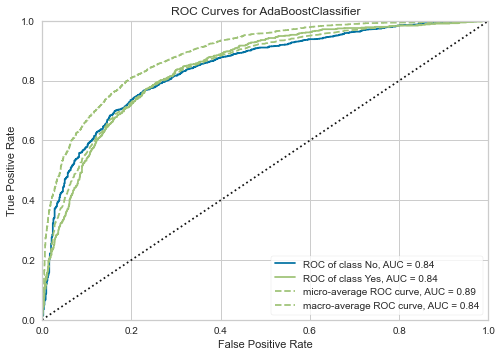

In [11]:
# AUC Plot
plot_model(tuned_best_model, plot = 'auc')

In [12]:
# plot model performance in dependence of features used; here recursive feature selection is being applied and may take long time to run
#plot_model(tuned_best_model, plot='rfe', fold=3)

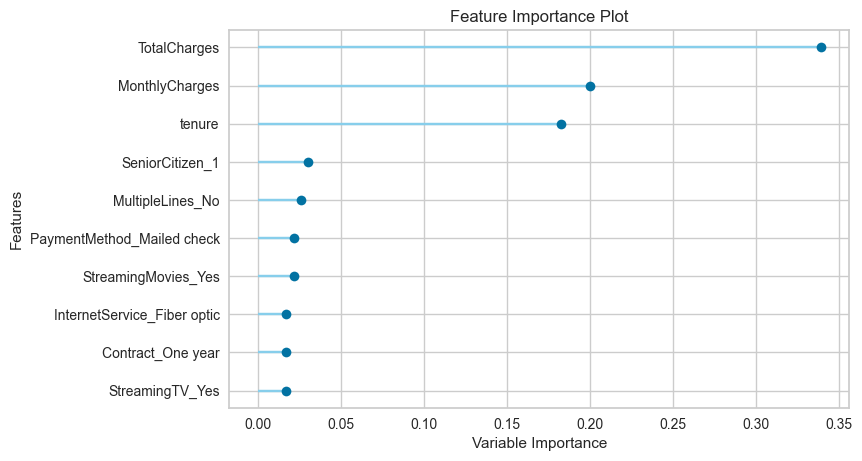

In [13]:
# Feature Importance Plot
plot_model(tuned_best_model, plot='feature')

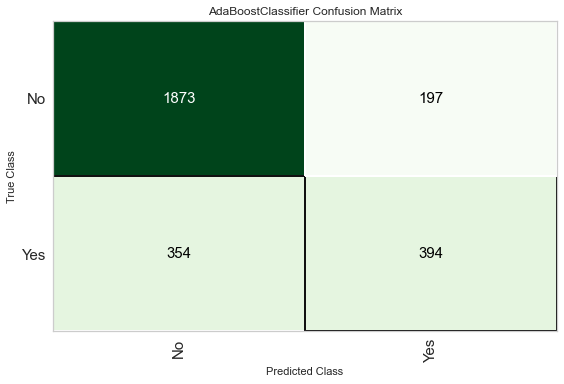

In [14]:
# Confusion Matrix
plot_model(tuned_best_model, plot='confusion_matrix')

## Adding a Custom Business Metric

In [15]:
# create a custom function
def calculate_profit(y, y_pred):
    tp = np.where((y_pred==1) & (y==1), (5000-1000), 0) # a true leads to a net profit of 4000
    fp = np.where((y_pred==1) & (y==0), -1000, 0) # a false positive leads to a net profit of -1000
    return np.sum([tp,fp])# add metric to PyCaret

add_metric('profit', 'Profit', calculate_profit)

Name                                                            Profit
Display Name                                                    Profit
Score Function       <function calculate_profit at 0x0000020A626BF820>
Scorer                                   make_scorer(calculate_profit)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: profit, dtype: object

In [16]:
# compare only trees and linear models to save a lot of time during model explainability in the next step
best_business_model = compare_models(include = ['lda','lr', 'dt', 'lightgbm', 'gbc', 'rf','dummy'],
                                     sort = 'Profit', 
                                     n_select = 1
                                     )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
lda,Linear Discriminant Analysis,0.7983,0.8370,0.5549,0.6389,0.5934,0.4603,0.4627,427000.0000,0.0120
lr,Logistic Regression,0.8014,0.8418,0.5397,0.6531,0.5905,0.4611,0.4650,419400.0000,0.0220
gbc,Gradient Boosting Classifier,0.8007,0.8448,0.5371,0.6517,0.5880,0.4584,0.4626,417000.0000,0.1220
lightgbm,Light Gradient Boosting Machine,0.7896,0.8296,0.5370,0.6203,0.5753,0.4365,0.4387,407600.0000,0.0360
rf,Random Forest Classifier,0.7827,0.8151,0.4719,0.6197,0.5353,0.3970,0.4035,358000.0000,0.1020
dt,Decision Tree Classifier,0.7240,0.6520,0.4978,0.4817,0.4892,0.3003,0.3006,325800.0000,0.0100
dummy,Dummy Classifier,0.7347,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0060


In [17]:
best_business_model

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [18]:
# tune best model
tuned_best_business_model = tune_model(best_business_model, 
                                       optimize='Profit')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
Fold,,,,,,,,
0,0.7858,0.8277,0.5625,0.6029,0.5820,0.4382,0.4387,421000.0000
1,0.7917,0.8166,0.5625,0.6176,0.5888,0.4497,0.4506,426000.0000
2,0.7941,0.8433,0.5134,0.6389,0.5693,0.4361,0.4406,395000.0000
3,0.8178,0.8489,0.6161,0.6699,0.6419,0.5199,0.5207,484000.0000
4,0.8071,0.8521,0.5333,0.6742,0.5955,0.4711,0.4767,422000.0000
Mean,0.7993,0.8377,0.5576,0.6407,0.5955,0.4630,0.4655,429600.0000
Std,0.0116,0.0135,0.0347,0.0281,0.0248,0.0310,0.0308,29329.8483


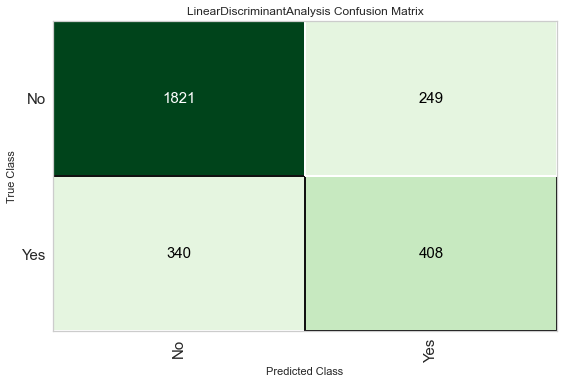

In [19]:
# confusion matrix
plot_model(tuned_best_business_model, plot = 'confusion_matrix')

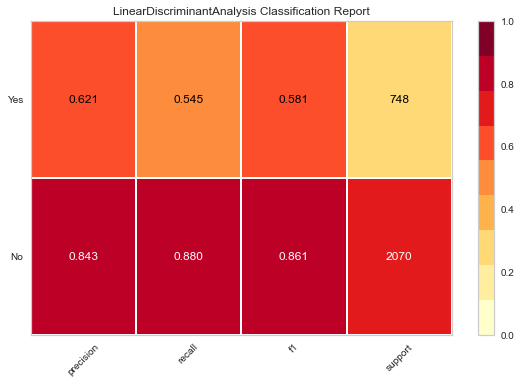

In [20]:
plot_model(tuned_best_business_model, plot = 'class_report')

# Finalize and Save Tuned Best Business Model

In [21]:
# finalize the model
final_model = finalize_model(tuned_best_business_model)

In [60]:
# save model to disk
filename = 'churn_model_pipeline'
deployment_filename = add_datetime_to_filename(filename) 
save_model(final_model, os.path.join(MODELPATH, deployment_filename))

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['customerID'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Churn',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 n...
                 ('dummy', Dummify(target='Churn')),
                 ('fix_perfect', Remove_100(target='Churn')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi',

In [24]:
# save log file
logs = get_logs(save=True)